<< The Big Data Challenge 2019 >>

Author : Andy RK Chang & 陳宇修

Create Date : Jul 05, 2019

Modify Date : Aug 01, 2019

Version : 1.12.1

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as plts 
import math
import glob
import os.path
from operator import mod
from scipy import stats
%matplotlib inline
import re

In [0]:
#a.drop([0],inplace = True)

## (*****) Read file from Google Drive

In [43]:
# Read file from Google Drive

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
#global variable definition and initial
#myDriveFilePath = './raw_data/'
myDriveFilePath = '/content/gdrive/My Drive/thubigdata2019/training230/'
recipeGroup = ['G11','G15','G17','G19','G32','G34','G48','G49']
#examFilePath = './exam_data/'
examFilePath =  '/content/gdrive/My Drive/thubigdata2019/exam/'
outFilePath =  '/content/gdrive/My Drive/thubigdata2019/'

PTCcolor = ['purple','red','coral','saddlebrown','orange'
            ,'olive','limegreen','blue','cyan','yellow']
rgColumns = ['filename','groupid','eqpid','date','sno','PTCno','count','mean','std',
             'min','Q1','Q2','Q3','max','median', 'startT','endT']


## , 'start2max_time','stable_time','max2ned_time','totaltime'

#v1.08 add
dropColumns = ['filename','groupid','eqpid','PTCno','sno', 'date']

In [0]:
## Function Module

#get RecipeGroup File List function
def getRecipeGroupFileList(aRecipeGroup):
    aFileList = glob.glob(myDriveFilePath + aRecipeGroup + "/*.txt")
    return aFileList
#get exam file list function
def getExamFileList():
    aFileList = glob.glob(examFilePath + "*.txt")
    return aFileList
#get file attribute function
def getFileAttributeList(aFile, aTraining):
    
    aFileAttributeList = []
    
    #修改為正則表達式
    if aTraining == True :
        aFileAttributeList.append(aFile)
        aFileAttributeList.append(re.search( r'(G\d+)', aFile).group())
        aFileAttributeList.append(re.search( r'(AC\(\d+x\d+\))',
                                            aFile,flags=re.IGNORECASE).group())
        aFileAttributeList.append(re.search( r'(\d{7,8})', aFile).group())
        aFileAttributeList.append(re.search( r'(00\d{1,3})', aFile).group())
    else:
        aFileAttributeList.append(aFile)
        aFileAttributeList.append('Nan')
        aFileAttributeList.append('Nan')
        aFileAttributeList.append('Nan')
        aFileAttributeList.append('Nan')
        
    return aFileAttributeList

# read recipe Group file data function

def readRecipeGroupFile(aFileName):
    _interpolate = False
    
    if _interpolate == False:
        fp = pd.read_csv(aFileName,sep="\t")    # 這裡不能用 \s+ 會有錯誤,如:G15 -PTC4 中間多個空格
        fp = fp.drop([0])                       # drop defoF
        fp = fp.drop(columns=['Unnamed: ' + str(len(fp.columns)-1)])# drop nonname column
        fp = fp.apply(pd.to_numeric, errors='coerce')  # str to numeric
        fp = fp[fp != 0 ] #讓為 0值變成NaN
        fp = fp.interpolate() #相NaN做內插
    else:
        #  v1.11如果要做內插法 使用這個,但由於只能填補0值,效果一般, 可用可不用
        fp = pd.read_csv(aFileName,sep="\t")    # 這裡不能用 \s+ 會有錯誤,如:G15 -PTC4 中間多個空格
        fp = fp.drop([0])                       # drop defoF
        fp = fp.drop(columns=['Unnamed: ' + str(len(fp.columns)-1)])# drop nonname column
        fp = fp.apply(pd.to_numeric, errors='coerce')  # str to numeric
        fp = fp[fp != 0 ] #讓為 0值變成NaN
        fp = fp.interpolate() #相NaN做內插
    
    return fp

def readExamFile(aFileName):
    fp = pd.read_csv(aFileName, sep = '\s+')
    fp = fp.drop([0])
    fp = fp.apply(pd.to_numeric, errors = 'coerce')
    
    return fp

#plot 成化曲線

def plotRecipeGroupFileCurve(aDf,aRG,aFN):
    
    #Draw Plot
    plt.figure(figsize = (10,8), dpi = 160)
    fig , ax = plt.subplots()
    
    ranges =  np.arange(len(aDf.columns))
    
    for i in ranges:
        aPTCno = aDf.columns[i].strip()
        aPTCno = aPTCno[aPTCno.find('PTC')+3: len(aPTCno)] #問題
        ax.plot(aDf.columns[i], data = aDf, color = PTCcolor[mod(int(aPTCno),10)],label=aDf.columns[i].strip())
        ax.axis([0,400,0,400])
        ax.set_title('recipe Group' + aRG + ' ; File No : ' + aFN, fontsize = 12, color = 'r')
    plt.legend()



# (*)Main()

In [46]:
_plogFlag = False
_plotFlag = False
_plotRecipeGroup = 7

rgdf = pd.DataFrame(columns = rgColumns)
                    
for i in range(len(recipeGroup)):
    
    aRecipeGroupFileList = getRecipeGroupFileList(recipeGroup[i])
    
    
    for j in range(len(aRecipeGroupFileList)):
                    
        df = readRecipeGroupFile(aRecipeGroupFileList[j])
                    
        for k in range(len(df.columns)):
            
            aFileAttributeList = getFileAttributeList(os.path.basename(aRecipeGroupFileList[j]), True)      
            aPTCno = df.columns[k].strip()
            aFileAttributeList.append(aPTCno[aPTCno.find('PTC'): len(aPTCno)])
            #6. PTCno
            aFileAttributeList.append(df.count()[k])                   #7. count
            aFileAttributeList.append(df.mean()[k])                    #8. mean
            aFileAttributeList.append(df.std()[k])                     #9. std
            aFileAttributeList.append(df.min()[k])                     #10. min
            aFileAttributeList.append(df.quantile(0.25)[k])            #11. Q1 25%
            aFileAttributeList.append(df.quantile(0.5)[k])             #12. Q2 50%
            aFileAttributeList.append(df.quantile(0.75)[k])            #13. Q3 75%
            aFileAttributeList.append(df.max()[k])                     #14. max
            aFileAttributeList.append(df.median()[k])                  #15. median
            
            aFileAttributeList.append(df.loc[1,df.columns[k]])  #16.startT
            aFileAttributeList.append(df.loc[df.count()[k],df.columns[k]])#17.endT
           
            if df.min()[k] > 0: #將出現PTC值為0的值去掉
                rgdf = rgdf.append(pd.DataFrame([aFileAttributeList],columns=rgColumns),ignore_index=True)

            # plot the same recipe group all file curve
        if i == _plotRecipeGroup and _plotFlag == True:        
            plotRecipeGroupFileCurve(df,recipeGroup[i], str(j))
            
rgdf.describe()

,mean,std,min,Q1,Q2,Q3,max,median,startT,endT
count,1745.000000,1745.000000,1745.000000,1745.000000,1745.000000,1745.000000,1745.000000,1745.000000,1745.000000,1745.000000
mean,226.745028,75.973363,75.399312,159.479876,261.563184,294.892748,297.266246,261.563184,75.648367,122.879771
std,31.706036,17.672552,6.021269,19.717307,46.907877,45.226236,44.259811,46.907877,5.278586,12.314646
min,96.707229,15.887122,21.300000,67.000000,94.571218,108.278598,162.000000,94.571218,63.200000,41.400000
25%,203.766346,61.162548,71.700000,156.600000,226.300000,257.700000,263.400000,226.300000,71.800000,113.500000
50%,213.945622,69.150735,74.700000,162.750000,248.500000,266.400000,270.400000,248.500000,74.900000,120.200000
75%,259.968148,95.961926,79.200000,167.900000,313.400000,350.400000,351.800000,313.400000,79.300000,131.900000
max,280.642357,127.952385,97.300000,201.300000,351.050000,357.900000,370.100000,351.050000,97.300000,149.100000


In [47]:
rgdf.head()

,filename,groupid,eqpid,date,sno,PTCno,count,mean,std,min,Q1,Q2,Q3,max,median,startT,endT
0,G11-1-AC(7X15)20160511-002_Export.txt,G11,AC(7X15),20160511,002,PTC10,258,273.026357,93.075181,77.5,193.850,323.60,352.70,354.0,323.60,77.6,127.4
1,G11-1-AC(7X15)20160511-002_Export.txt,G11,AC(7X15),20160511,002,PTC11,258,275.516667,93.810080,77.4,195.175,332.40,353.70,354.3,332.40,77.4,116.1
2,G11-1-AC(7X15)20160511-002_Export.txt,G11,AC(7X15),20160511,002,PTC12,258,273.703876,91.688239,77.5,196.925,321.75,352.65,354.3,321.75,77.6,139.5
3,G11-1-AC(7X15)20160511-002_Export.txt,G11,AC(7X15),20160511,002,PTC13,258,275.922868,93.082210,85.4,195.700,329.50,354.50,355.0,329.50,85.4,118.2
4,G11-1-AC(7X15)20160511-002_Export.txt,G11,AC(7X15),20160511,002,PTC14,258,275.451550,92.877829,85.0,194.100,328.65,354.30,354.6,328.65,85.0,119.6


## Plot File Curve

In [48]:
_plotFileCurve = True
if _plotFileCurve == True:
    for i in range(len(recipeGroup)):
        aRecipeGroupFileList = getRecipeGroupFileList(recipeGroup[i])

        for j in range(len(aRecipeGroupFileList)):

            df = readRecipeGroupFile(aRecipeGroupFileList[j])
            plotRecipeGroupFileCurve(df, recipeGroup[i],str(j+1))

Output hidden; open in https://colab.research.google.com to view.

# Classification Model Build

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import svm,tree
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
import lightgbm

In [0]:
# df=df.values (dataframe to array)
rgdf_data = rgdf.drop(dropColumns, axis = 1)   #v1.08
rgdf_target = rgdf['groupid'].values
classifiers = []

In [51]:
rgdf_data.head(3)

,count,mean,std,min,Q1,Q2,Q3,max,median,startT,endT
0,258,273.026357,93.075181,77.5,193.850,323.60,352.70,354.0,323.60,77.6,127.4
1,258,275.516667,93.810080,77.4,195.175,332.40,353.70,354.3,332.40,77.4,116.1
2,258,273.703876,91.688239,77.5,196.925,321.75,352.65,354.3,321.75,77.6,139.5


In [0]:
drop_G = lambda x :int(x[1:])
func = np.vectorize(drop_G)
rgdf_target = func(rgdf_target) #去掉G11前的G ，並轉呈int

In [0]:
train_x , test_x , train_y , test_y = train_test_split(rgdf_data,rgdf_target
                                                       ,test_size=0.2,random_state = 321)

In [0]:
train_x = train_x.apply(pd.to_numeric, errors='coerce')                       # str to numeric
train_y = train_y.astype(np.int)  # numpy array str to int

test_x = test_x.apply(pd.to_numeric, errors='coerce')                       # str to numeric
test_y = test_y.astype(np.int)  # numpy array str to int

# 模型建立

### 1. KNN Model

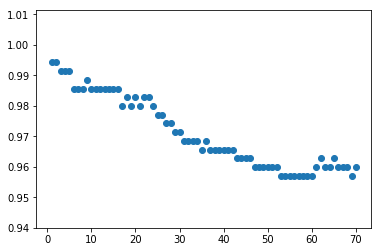

1


In [55]:
#選擇k
accuracies = []
for i in range(1,round(0.05 * train_x.shape[0]) + 1):
    clf = KNeighborsClassifier(n_neighbors = i)
    rg_clf = clf.fit(train_x,train_y)
    test_y_predicted = rg_clf.predict(test_x)
    accuracy = metrics.accuracy_score(test_y,test_y_predicted)
    accuracies.append(accuracy)
#視覺化
plt.scatter(range(1,round(0.05 * train_x.shape[0]) + 1),accuracies)
plt.show()
appr_k = accuracies.index(max(accuracies)) + 1
print(appr_k)    

[19 32 49 48 17 48 32 49 34 32 34 49 19 15 34 49 15 48 19 49 34 17 32 32
 49 11 32 34 34 15 32 34 34 32 34 32 49 19 19 32 34 11 48 19 34 48 32 32
 11 48 49 32 48 49 48 19 49 17 15 48 15 11 17 11 19 17 15 19 49 15 17 49
 15 34 32 34 48 15 49 34 32 48 34 17 48 48 48 32 11 15 17 48 49 49 15 32
 49 17 48 11 48 48 32 49 49 11 48 48 19 48 19 19 15 32 15 49 15 48 32 19
 34 34 32 11 32 34 32 34 48 34 48 15 48 19 15 19 48 11 32 19 15 48 17 11
 34 19 15 48 32 48 15 15 48 19 34 34 32 19 49 15 19 32 15 34 34 32 19 11
 19 49 49 11 11 19 34 15 34 19 15 32 49 48 11 49 32 19 17 49 32 48 11 49
 34 11 19 49 34 49 32 17 34 15 49 19 15 11 48 34 11 32 48 17 11 34 32 48
 48 19 48 49 49 34 19 32 49 19 34 19 48 15 15 48 19 49 48 17 15 32 49 48
 34 15 15 32 48 49 17 11 19 17 49 34 34 34 11 11 32 19 19 48 32 15 49 32
 34 49 49 48 11 11 48 49 48 49 11 48 34 15 32 15 32 15 48 49 48 19 15 34
 48 49 19 48 48 32 48 32 32 48 19 19 15 15 49 15 19 34 49 19 11 11 49 15
 34 32 48 19 34 34 49 15 17 32 11 32 48 32 19 48 19

<Figure size 1600x1280 with 0 Axes>

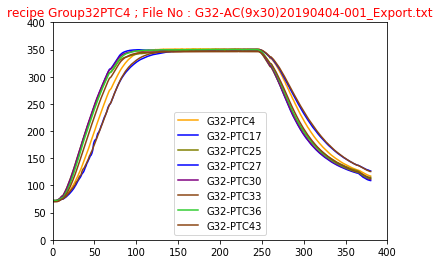

<Figure size 1600x1280 with 0 Axes>

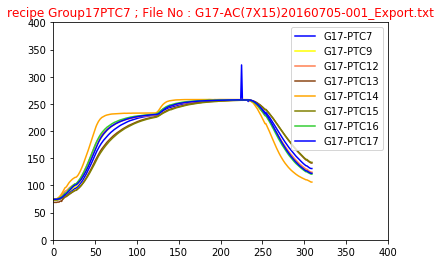

In [56]:
#建立分類器
clf = KNeighborsClassifier(n_neighbors = appr_k)
rg_clf = clf.fit(train_x,train_y)

#預測
test_y_predicted = rg_clf.predict(test_x)
print(test_y_predicted)

#標準答案
print(test_y)

accuracy = metrics.accuracy_score(test_y,test_y_predicted)

print('==============')

print('KNN Model , K = 1, Accuracy Rate = ', accuracy * 100)

print("==============")
for i in range(len(test_y)):
    if test_y[i] != test_y_predicted[i]:
        print(i , ' test_y', test_y[i], '; test_y_predicted', 
              test_y_predicted[i], '; test_data_index', test_x.index[i])
        amisMatchFilePath = myDriveFilePath + 'G'+str(test_y[i]) + '/' + rgdf.loc[rgdf.index[test_x.index[i]] , 'filename']
        misdf = readRecipeGroupFile(amisMatchFilePath)
        plotRecipeGroupFileCurve(misdf,str(test_y[i]) +  rgdf.loc[rgdf.index[test_x.index[i]], 'PTCno']
                                 ,  rgdf.loc[rgdf.index[test_x.index[i]], 'filename'])

In [0]:
knn_model = KNeighborsClassifier(n_neighbors = appr_k)

### 2. SVM模型

In [0]:
C = 1.0  # SVM regularization parameter
svm_model = svm.SVC(kernel='poly', degree=3, C=C)

### 3. RandomForestClassifier 模型

In [0]:
rf_model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.002, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=10, verbose=0, warm_start=False)

### 4. LightGBM 模型

In [60]:
estimator = lightgbm.LGBMClassifier()

param_grid = {
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [20, 40,50],
    'max_depth':[3,4,5]
}

gbm = GridSearchCV(estimator, param_grid)

gbm.fit(train_x,train_y)

print('用网格搜索找到的最优超参数为:')
print(gbm.best_params_)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


用网格搜索找到的最优超参数为:
{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50}


In [0]:
lgb_model =  lightgbm.LGBMClassifier(learning_rate= 0.1,max_depth= 3, n_estimators=50)

### 5. XGBoost Classifier Model 模型

In [0]:
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn import metrics

In [63]:
xgb_model = XGBClassifier(learning_rate=0.01,
                      n_estimators=50,           # 樹的個數-10棵樹建立 xgboost
                      max_depth=5,               # 樹的深度
                      min_child_weight = 1,      # 葉子節點最小權重
                      gamma=0.,                  # 懲罰項中葉子結點個數前的參數
                      subsample=0.8,               # 0.8樣本建立決策樹
                      colsample_btree=0.8,         # 0.8特徵建立決策樹
                      scale_pos_weight=1,        # 解決樣本個數不平衡的問題
                      random_state=27,           # 隨機數
                      slient = 0
                      )
xgb_model.fit(train_x,train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_btree=0.8,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0.0, learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=50, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=27,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, slient=0, subsample=0.8, verbosity=1)

In [64]:
# 預測
test_y, pred_y = test_y, xgb_model.predict(test_x)
print("Accuracy : %.4g" % metrics.accuracy_score(test_y, pred_y)) 

xgb_train_y_proba = xgb_model.predict_proba(train_x)[:,1]
#print("AUC Score (Train): %f" % metrics.roc_auc_score(xgb_train_y, xgb_train_y_proba))

xgb_test_y_proba = xgb_model.predict_proba(test_x)[:,1]
#print("AUC Score (Test): %f" % metrics.roc_auc_score(xgb_test_y, xgb_test_y_proba))

Accuracy : 0.9857


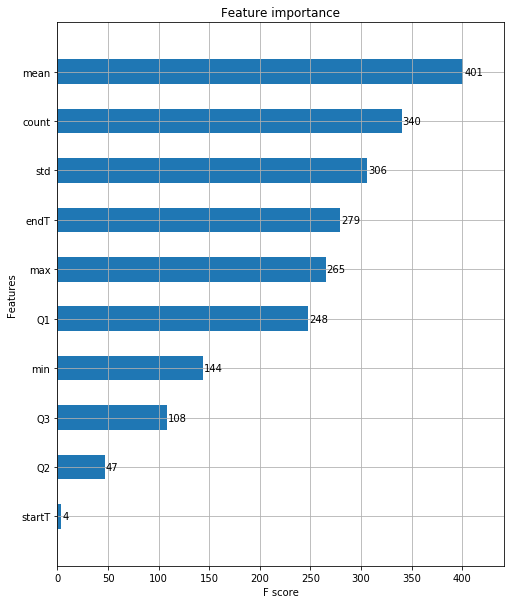

In [65]:
### 特征重要性
fig,ax = plt.subplots(figsize=(8,10))
plot_importance(xgb_model,height=0.5,max_num_features=64,ax=ax)
plt.show()

89  test_y 15 ; test_y_predicted 19 ; test_data_index 348
93  test_y 32 ; test_y_predicted 49 ; test_data_index 941
108  test_y 19 ; test_y_predicted 17 ; test_data_index 539
147  test_y 17 ; test_y_predicted 48 ; test_data_index 458
235  test_y 17 ; test_y_predicted 19 ; test_data_index 435


<Figure size 1600x1280 with 0 Axes>

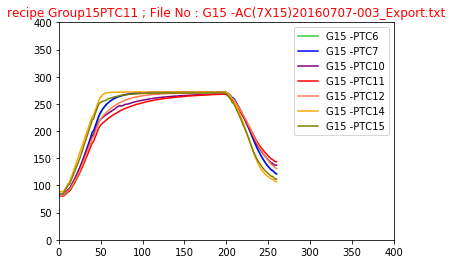

<Figure size 1600x1280 with 0 Axes>

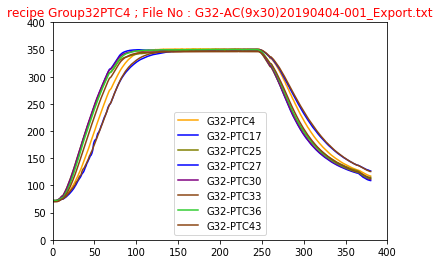

<Figure size 1600x1280 with 0 Axes>

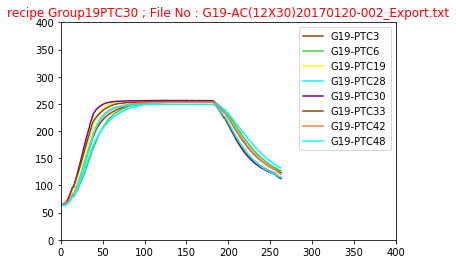

<Figure size 1600x1280 with 0 Axes>

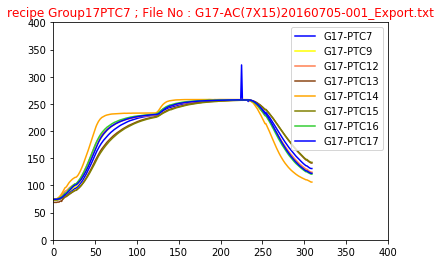

<Figure size 1600x1280 with 0 Axes>

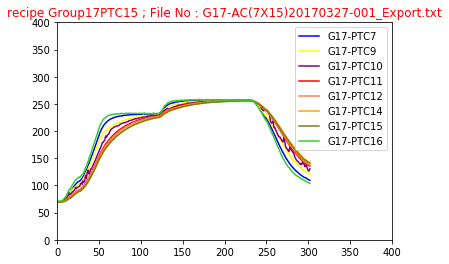

In [66]:
for i in range(len(test_y)):
    if test_y[i] != pred_y[i]:
        print(i , ' test_y', test_y[i], '; test_y_predicted', 
              pred_y[i], '; test_data_index', test_x.index[i])
        amisMatchFilePath = myDriveFilePath + 'G'+ str(test_y[i]) + '/' + rgdf.loc[rgdf.index[test_x.index[i]] , 'filename']
        misdf = readRecipeGroupFile(amisMatchFilePath)
        plotRecipeGroupFileCurve(misdf,str(test_y[i]) +  rgdf.loc[rgdf.index[test_x.index[i]], 'PTCno'],  rgdf.loc[rgdf.index[test_x.index[i]], 'filename'])


# Build Model

In [0]:
#### Build Model
classifiers.append(knn_model)
classifiers.append(svm_model)
classifiers.append(rf_model)
classifiers.append(lgb_model)
classifiers.append(xgb_model)

In [68]:
for clf in classifiers:
    clf.fit(train_x, train_y)
    y_pred= clf.predict(test_x)
    acc = accuracy_score(test_y, y_pred)
    print("Accuracy of %s is %s" % (clf, acc))
    print('     ')
    cm = confusion_matrix(test_y, y_pred)
    print("Confusion Matrix of %s is " % (clf))
    print(cm)
    print('     ')

Accuracy of KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform') is 0.994269340974212
     
Confusion Matrix of KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform') is 
[[29  0  0  0  0  0  0  0]
 [ 0 44  0  0  0  0  0  0]
 [ 0  0 19  0  0  0  1  0]
 [ 0  0  0 48  0  0  0  0]
 [ 0  0  0  0 50  0  0  1]
 [ 0  0  0  0  0 52  0  0]
 [ 0  0  0  0  0  0 59  0]
 [ 0  0  0  0  0  0  0 46]]
     
Accuracy of SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='poly', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False) is 1.0
     
Confusion Matrix of SVC(C=1.0, cache_size=200, class_weight=None, coef0=

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.002, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=10, verbose=0,
                       warm_start=False) is 0.9914040114613181
     
Confusion Matrix of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.002, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=10, verbose=0,
     

## Prediction Exam - 0722 Dataset 36 sample

In [69]:
# exman File 
_logFlag = False
_plotFlag = False
_plotRecipeGroup = 7

examdf = pd.DataFrame(columns=rgColumns)

aExamFileList = getExamFileList()

  
for j in range(len(aExamFileList)):
    edf = readExamFile(aExamFileList[j])
    
    for k in range(len(edf.columns)):
    
        aFileAttributeList = getFileAttributeList(os.path.basename(aExamFileList[j]), False)     

        aPTCno = edf.columns[k].strip()      
        aFileAttributeList.append(aPTCno[aPTCno.find('PTC'): len(aPTCno)])                   #6. PTCno
        aFileAttributeList.append(edf.count()[k])                   #7. count
        aFileAttributeList.append(edf.mean()[k])                    #8. mean
        aFileAttributeList.append(edf.std()[k])                     #9. std
        aFileAttributeList.append(edf.min()[k])                     #10. min
        aFileAttributeList.append(edf.quantile(0.25)[k])            #11. Q1 25%
        aFileAttributeList.append(edf.quantile(0.5)[k])             #12. Q2 50%
        aFileAttributeList.append(edf.quantile(0.75)[k])            #13. Q3 75%
        aFileAttributeList.append(edf.max()[k])                     #14. max
        aFileAttributeList.append(edf.median()[k])                  #15. median
        aFileAttributeList.append(df.loc[1, df.columns[k]])         #16. startT
        aFileAttributeList.append(df.loc[df.count()[k], df.columns[k]])   #17.endT        
        
        
        #aFileAttributeList.append()   #16. start2max_time
        #aFileAttributeList.append()   #17. stable_time
        #aFileAttributeList.append()   #18. max2end_time
        #aFileAttributeList.append()   #19. totaltime

        if j == 0 and _logFlag == True:
            print(aFileAttributeList)

        examdf = examdf.append(pd.DataFrame([aFileAttributeList], columns=rgColumns),ignore_index=True) 

        # plot the same recipe group all file curve
        if i == _plotRecipeGroup and _plotFlag == True:        
            plotRecipeGroupFileCurve(examdf, ' ', aExamFileList[j])
      
examdf.describe()

,mean,std,min,Q1,Q2,Q3,max,median,startT,endT
count,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000
mean,226.149534,76.509530,75.899638,158.348913,259.369928,295.694203,298.330072,259.369928,71.743841,132.422101
std,31.173450,17.101284,9.592677,19.729394,47.302535,43.850275,42.924229,47.302535,1.414393,5.919980
min,182.951232,52.018406,0.000000,111.200000,179.500000,247.975000,249.600000,179.500000,69.500000,121.800000
25%,202.996052,62.225377,72.875000,158.012500,223.787500,259.668750,264.100000,223.787500,70.700000,124.500000
50%,216.629857,69.175375,75.800000,163.325000,249.925000,269.687500,271.150000,249.925000,71.100000,134.700000
75%,258.017422,96.275169,79.000000,168.187500,306.325000,349.781250,350.850000,306.325000,73.100000,137.000000
max,278.883200,102.596601,99.700000,204.175000,336.100000,356.300000,360.500000,336.100000,73.800000,138.500000


In [70]:
examdf_data = examdf.drop(['filename','groupid','eqpid','PTCno','sno', 'date'], axis = 1)
examdf_data.head(3)

,count,mean,std,min,Q1,Q2,Q3,max,median,startT,endT
0,308,201.468506,57.475360,71.7,165.525,222.55,250.775,257.2,222.55,70.9,121.8
1,308,203.058442,57.325846,72.1,164.775,225.30,252.350,257.6,225.30,71.1,134.7
2,308,205.330519,57.548820,72.3,160.075,229.55,255.225,257.3,229.55,73.5,135.1


## get exam predict result Function ()

In [0]:
def genExamResultSummary(aExamdf,aExamPred):
    #define exam result columns name
    
    rangePTCno = np.arange(50)
    examResultColumns = []
    for i in rangePTCno:
        examResultColumns.append(str(rangePTCno[i]))
    
    aExamResultdf = pd.DataFrame(columns = examResultColumns)
    aExamFileList = getExamFileList()
    
    for i in range(len(aExamFileList)):
        
        aExamFileName = os.path.basename(aExamFileList[i])
        aExamResultdf = aExamResultdf.append({'0': aExamFileName}, ignore_index=True)
        
        for j in range(len(aExamdf)):
            if aExamFileName == aExamdf.loc[j,'filename']:
                
                aPTCno = aExamdf.loc[j,'PTCno']
                aPTCno = aPTCno[3:len(aPTCno)]
                
                aExamResultdf.at[i,aPTCno] = aExamPred[j]
    
    return aExamResultdf

  
def genExamResult(aExamResultdf):  
  
  # v1.09

    aPredGroupList = []
    aConfidenceIndexList = []
    rangei = np.arange(aExamResultdf.shape[0])

    for i in rangei:     
  
    # get the predicted group count for each TXT file
        predGroupCount = aExamResultdf.iloc[i, 1:49].nunique()

        if predGroupCount == 1 :
    
            aPredGroupList.append(aExamResultdf.stack().groupby(level=0).apply(lambda x: x.unique().tolist())[i][predGroupCount])
            aConfidenceIndexList.append(1)
        elif predGroupCount > 1 :
            aTotalCount = aExamResultdf.shape[1] - aExamResultdf.apply(lambda row: sum(row[:] != row[:]) ,axis=1)[i] - 1
            maxCount = 0
            maxGroupNo = ''
            rangej = np.arange(predGroupCount)
            for j in rangej:

                aGroupNo = aExamResultdf.stack().groupby(level=0).apply(lambda x: x.unique().tolist())[i][j+1]
                aCount = aExamResultdf.apply(lambda row: sum(row[:]==aGroupNo) ,axis=1)[i]
            if aCount > maxCount:
                maxCount = aCount
                maxGroupNo = aGroupNo
    
            aPredGroupList.append(maxGroupNo)
            aConfidenceIndexList.append(maxCount/aTotalCount)
  
    aExamResultdf['PredictedGroup'] = aPredGroupList  
    aExamResultdf['ConfendenceIndex'] = aConfidenceIndexList  
  
    return aExamResultdf
     

In [0]:
#### Predictor
predictor = []

predictor.append(knn_model)
predictor.append(svm_model)
predictor.append(rf_model)
predictor.append(lgb_model)
predictor.append(xgb_model)

In [73]:
_plotPredictFile = False

examdf_data = examdf_data.apply(pd.to_numeric, errors='coerce')                       # str to numeric
examEnsemble = pd.DataFrame()
examEnsembleColumns = ['KNN', 'SVM', 'RF', 'LGB', 'XGB']

i = 0

for prd  in classifiers:
  
  exam_predicted = prd.predict(examdf_data)  
  aExamResultdf = genExamResultSummary(examdf, exam_predicted)
  aExamResultdf = genExamResult(aExamResultdf)
  
  # plot predict file
  
  if _plotPredictFile == True:
    print(prd, exam_predicted.shape)
    print(exam_predicted)
    print('    ')
    print(aExamResultdf[['0', 'PredictedGroup', 'ConfendenceIndex', '1', '2', '3', '4', '5', '6', '7', '8']])
    print('================================================================================================= ')
    plotPredFile(aExamResultdf,exam_predicted)
  
  #examEnsemble[str(i)] = aExamResultdf['PredictedGroup']
  examEnsemble[i] = aExamResultdf['PredictedGroup']
  i = i + 1

examEnsemble['filename'] = aExamResultdf['0']
print(examEnsemble)

     0   1   2   3   4 filename
0   17  17  17  17  17   10.txt
1   19  19  19  19  19   11.txt
2   32  49  32  32  32   17.txt
3   49  49  32  32  32   18.txt
4   32  49  32  32  32   15.txt
5   32  32  32  32  32   16.txt
6   34  34  34  48  34   19.txt
7   34  34  34  48  48   21.txt
8   34  34  34  48  34   20.txt
9   48  48  48  48  48   26.txt
10  48  48  48  17  48   25.txt
11  34  34  34  48  34   23.txt
12  34  34  34  48  34   22.txt
13  48  48  48  48  48   27.txt
14  34  34  34  48  34   24.txt
15  48  48  48  48  48   28.txt
16  15  15  15  15  15    3.txt
17  48  48  48  48  48   29.txt
18  49  49  49  49  49   36.txt
19  49  49  49  49  49   35.txt
20  49  49  49  49  49   32.txt
21  49  49  49  49  49   31.txt
22  48  48  48  48  48   30.txt
23  49  49  49  49  49   33.txt
24  49  49  49  49  49   34.txt
25  15  15  15  15  15    8.txt
26  15  15  15  15  15    6.txt
27  11  11  11  11  11    1.txt
28  11  11  11  11  11    2.txt
29  15  15  15  15  15    4.txt
30  15  

In [0]:
examEnsemble['value'] = examEnsemble.apply(lambda x:x.mode(),axis = 1)

In [0]:
examEnsemble.rename(columns = {0:'knn_model',1:'svm_model',2:'rf_model',3:'lgb_model',
                               4:'xgb_model','0':'filename','value':'Final_Result'},inplace = True)

In [0]:
examEnsemble.index = examEnsemble['filename'].apply(lambda x: int(re.search( r'(\d{1,2})',x).group()))

In [0]:
examEnsemble = examEnsemble.sort_index()

In [0]:
examEnsemble.to_csv(outFilePath + 'examResult321.csv')